In this notebook, we'll walk through the process of starting with a shapefile of an AOI (area of interest) where there has been change over time, creating `Select` objects for `before` and `after` periods, and visualizing our AOI and `Select` objects.

Before we do anything else, let IPython know **not** to cut off any of our cell outputs:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = lines => false;

<IPython.core.display.Javascript object>

Run the necessary imports:

In [2]:
from vizard import enter_ard_creds, display_aoi_viz, generate_iframe_html, display_result_tiles
from max_ard.processing import convert_shp_gpkg_to_shapely, shape_wrangler
from max_ard import Select, ARDCollection
from IPython.core.getipython import get_ipython
from warnings import catch_warnings, simplefilter
import webbrowser

When you run this cell you will be prompted to enter your ARD credentials (you need to be authenticated in order to run the rest of this notebook):

In [3]:
enter_ard_creds()

ARD username (email address): maja.cannavo@maxar.com
ARD password: ········


Now on to the interesting stuff!

We started with [Maxar PCM](https://www.maxar.com/products/persistent-change-monitoring) (Persistent Change Monitoring) data, looked at the area we were interested in, and selected for the change that had occurred in 2017. Our output shapefile was `select_2017.shp` (see below).

Convert your AOI geometry into an acceptable input for a `Select`:

In [4]:
aoi = '../apac-notebooks/Los_Angeles/select_2017.shp' # path to multipolygon shapefile

# conver the shapefile to a Shapely shape
shapely_aoi = convert_shp_gpkg_to_shapely(aoi)

# now run the shape through shape_wrangler to get it in an acceptable format for a Select input
fixed_aoi = shape_wrangler(shapely_aoi, convex_hull=True)

Take a look at your `Select`-ready AOI geometry:

In [5]:
display_aoi_viz(fixed_aoi)

Specify the beginning and ending dates you'd like to search within:

In [6]:
before_start_date = "2014-01-01"
before_end_date = "2015-01-01"

after_start_date = "2020-01-01"
after_end_date = "2021-01-01"

Enter the stack depth you're looking for:

In [7]:
stack_depth = 2

Specify the minimum cloud-free percentage and minimum data percentage you'd like:

In [8]:
min_cloudfree_pct = 95
min_data_pct = 75

Now we'll construct the query using the variables you defined above:

In [9]:
before_datetime =  f'{before_start_date}T00:00:00Z/{before_end_date}T00:00:00Z'
after_datetime =  f'{after_start_date}T00:00:00Z/{after_end_date}T00:00:00Z'

query = {
    "aoi:cloud_free_percentage": {
        "gte": min_cloudfree_pct
    },
    "aoi:data_percentage": {
        "gte": min_data_pct
    }
}

s_before = Select(datetime=before_datetime, intersects=fixed_aoi, query=query, stack_depth=stack_depth)
s_after = Select(datetime=after_datetime, intersects=fixed_aoi, query=query, stack_depth=stack_depth)

Run the following cell to see the full request objects if you're curious:

In [10]:
print('s_before: ', s_before.request.to_payload(), '\n')
print('s_after: ', s_after.request.to_payload())

s_before:  {'datetime': '2014-01-01T00:00:00Z/2015-01-01T00:00:00Z', 'stack_depth': 2, 'intersects': 'POLYGON ((-118.3215277777778 34.18708333333333, -118.3215277777778 34.19875, -118.3376388888889 34.19875, -118.3376388888889 34.18708333333333, -118.3215277777778 34.18708333333333))', 'query': {'aoi:cloud_free_percentage': {'gte': 95}, 'aoi:data_percentage': {'gte': 75}}} 

s_after:  {'datetime': '2020-01-01T00:00:00Z/2021-01-01T00:00:00Z', 'stack_depth': 2, 'intersects': 'POLYGON ((-118.3215277777778 34.18708333333333, -118.3215277777778 34.19875, -118.3376388888889 34.19875, -118.3376388888889 34.18708333333333, -118.3215277777778 34.18708333333333))', 'query': {'aoi:cloud_free_percentage': {'gte': 95}, 'aoi:data_percentage': {'gte': 75}}}


Now we're ready to submit the requests:

In [11]:
s_before.submit()
s_before.wait_for_success()
print(f'{str(s_before)[5:-1]}: {s_before.status}')

s_after.submit()
s_after.wait_for_success()
print(f'{str(s_after)[5:-1]}: {s_after.status}')

Select 5727006192275775881: SUCCEEDED
Select 5727006226093362226: SUCCEEDED


Save the `Select ID`s as variables:

In [12]:
before_id = s_before.select_id
after_id = s_after.select_id

We're about to visualize the `Select` objects. First, adjust the pixel dimensions and alignments of the iframes for your `before` and `after` `Select` objects if you'd like.

In [13]:
before_height = '450'
before_width = '600'

after_height = '450'
after_width = '600'

before_align = 'left'
after_align = 'right'

Run this cell to generate your visualizations:

In [14]:
before_iframe_html = generate_iframe_html(
    id=before_id, 
    height=before_height, 
    width=before_width, 
    align=before_align
)

after_iframe_html = generate_iframe_html(
    id=after_id, 
    height=after_height, 
    width=after_width, 
    align=after_align
)

Now let's output the visualizations into the notebook:

In [15]:
with catch_warnings(): 
    
    # IPython will advise us to use its built-in display feature instead--don't listen
    simplefilter('ignore')
    
    get_ipython().run_cell_magic('html', '', before_iframe_html)
    get_ipython().run_cell_magic('html', '', after_iframe_html)

Run this cell if you'd like to open your `Select` visualizations in new tabs for further exploration.

In [16]:
before_link = s_before.get_signed_link('html')
after_link = s_after.get_signed_link('html')

webbrowser.open(before_link)
webbrowser.open(after_link)

True

Run this cell to see a comparison of "before" and "after" imagery from the cell where our AOI best fits.

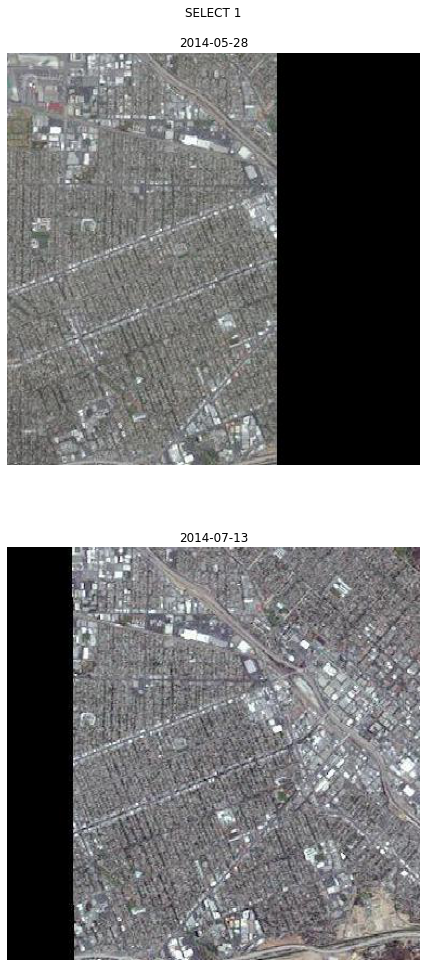

In [18]:
display_result_tiles(s_before, 'Z11-031311102133') # we found the cell ID from examining the Select visualization